In [31]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchdiffeq import odeint_adjoint as odeint

In [38]:
def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)
rtol = 1e-3
atol = 1e-3

In [39]:
class ConcatConv2d(nn.Module):

    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, groups=1, bias=True, transpose=False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=ksize, stride=stride, padding=padding, dilation=dilation, groups=groups,
            bias=bias
        )

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)

class ODEfunc(nn.Module):

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm3 = norm(dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(t, out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        out = self.norm3(out)
        return out


class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=rtol, atol=atol)
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value

class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)



In [40]:
downsampling_layers = [
nn.Conv2d(1, 64, 3, 1),
norm(64),
nn.ReLU(inplace=True),
nn.Conv2d(64, 64, 4, 2, 1),
norm(64),
nn.ReLU(inplace=True),
nn.Conv2d(64, 64, 4, 2, 1),
]
feature_layers = [ODEBlock(ODEfunc(64))]
fc_layers = [norm(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(64, 10)]
model = nn.Sequential(
    *downsampling_layers,
    *feature_layers,
    *fc_layers
)

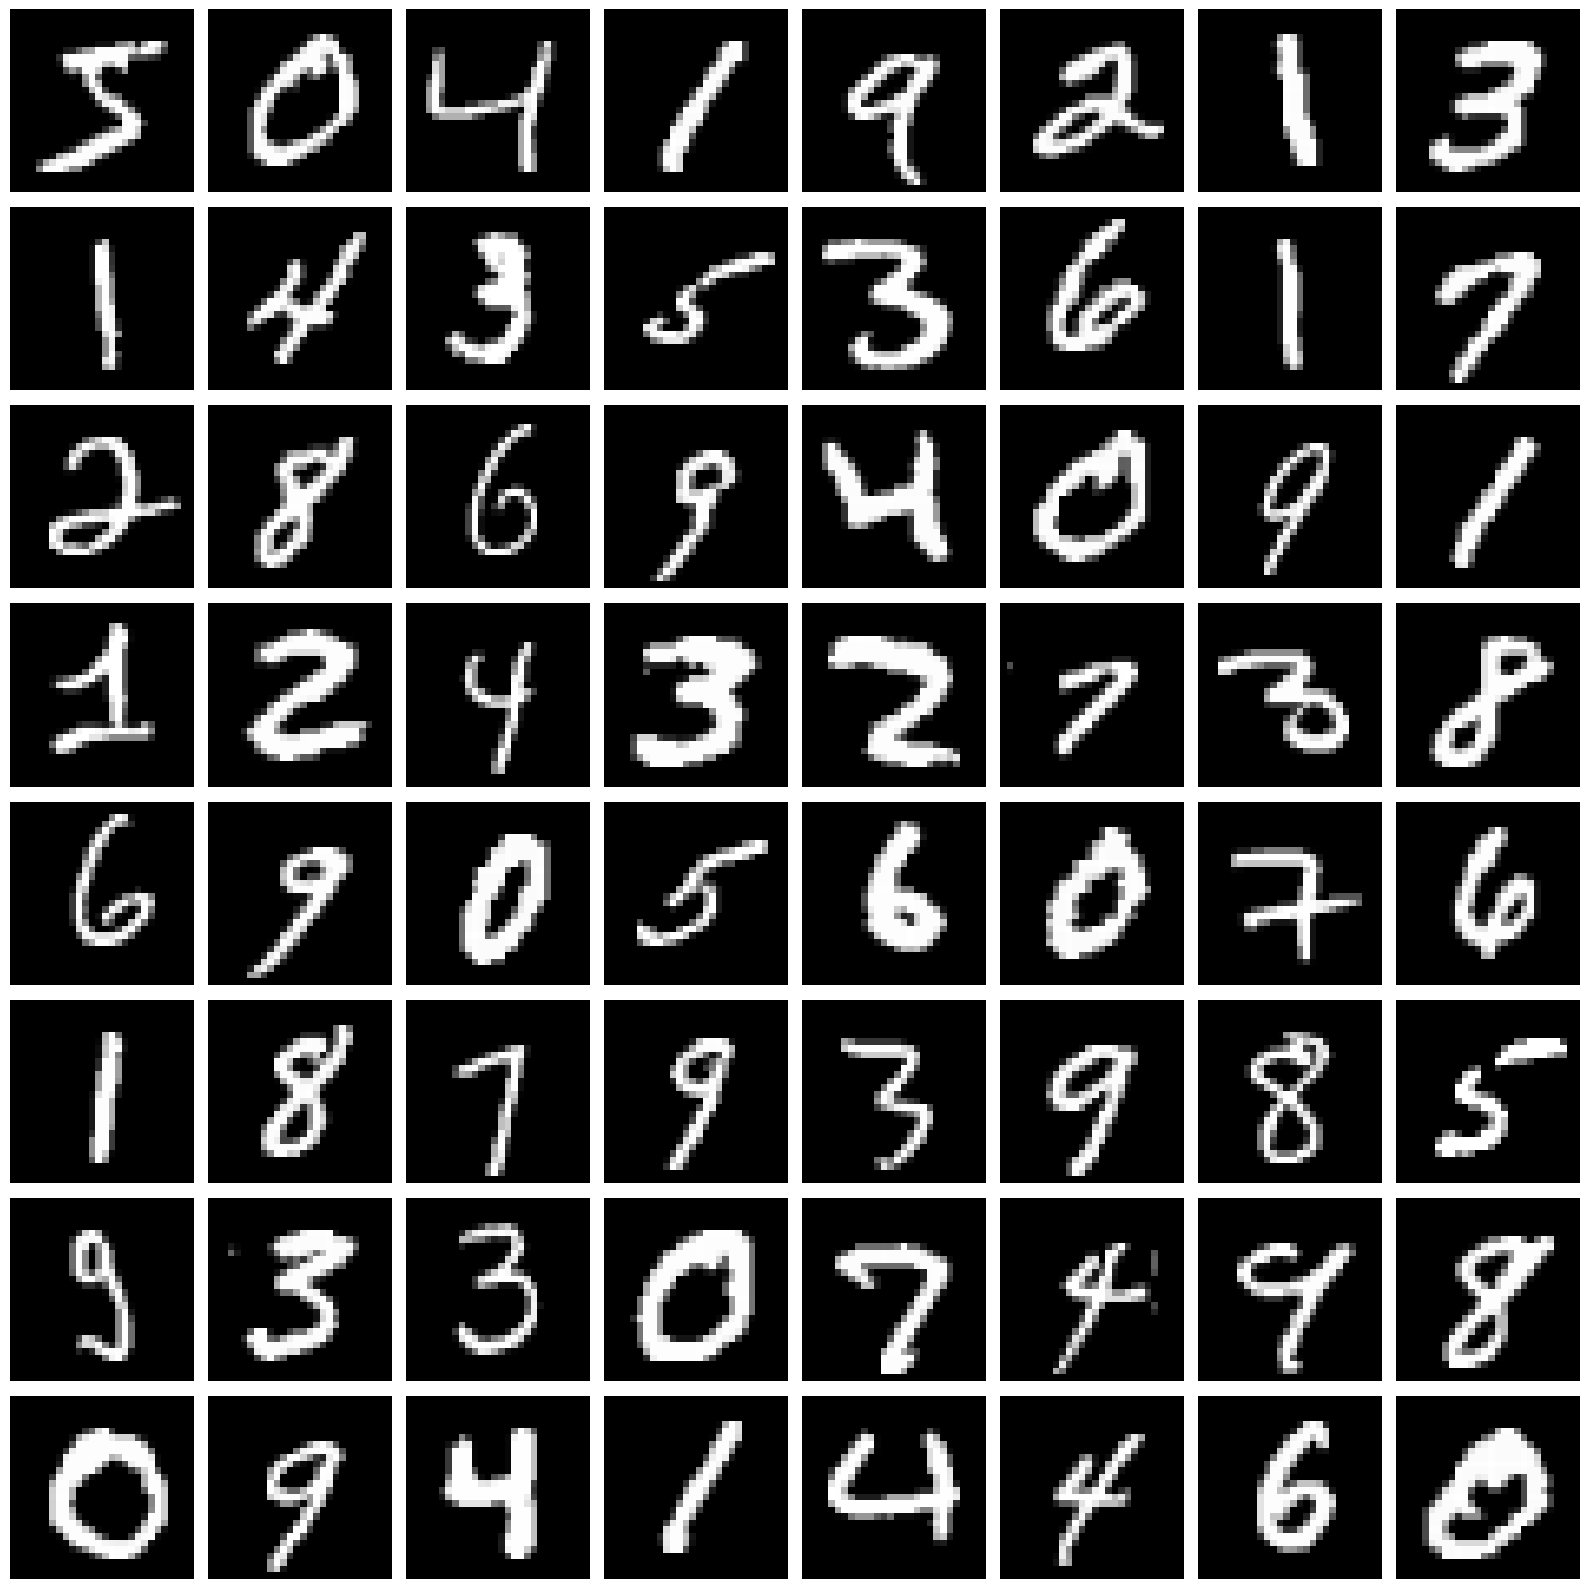

In [41]:
transform = transforms.Compose([
transforms.RandomCrop(28, padding=4),
transforms.ToTensor(),
])
mnist = datasets.MNIST(root='./.data/mnist', train=True, transform=transform)
dataloader = DataLoader(mnist, batch_size=64, shuffle=True)
def show_images(images, ncols=8):
    nrows = (len(images) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_images(mnist.data[:64].numpy())

In [42]:
## Load model from experiment folder 

model_state_dict = torch.load('./experiment/model.pth',weights_only=False)
model.load_state_dict(model_state_dict['state_dict'])
# Set model to evaluation mode
model.eval()

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): GroupNorm(32, 64, eps=1e-05, affine=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): GroupNorm(32, 64, eps=1e-05, affine=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ODEBlock(
    (odefunc): ODEfunc(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu): ReLU(inplace=True)
      (conv1): ConcatConv2d(
        (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv2): ConcatConv2d(
        (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm3): GroupNorm(32, 64, eps=1e-05, affine=True)
    )
  )
  (8): GroupNorm(32, 64, eps=1e-05, affine=True)
  (9): ReLU(inplace=True)
  (10): AdaptiveAvgPool2d(output_size=(1, 1))
  (11): Flatten()


Output: 5


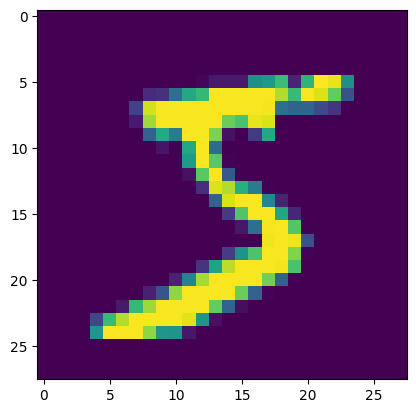

In [56]:
plt.imshow(mnist.data[0].numpy())
# Single evaluation of the model on a single image
with torch.no_grad():
    image = mnist.data[0].unsqueeze(0).unsqueeze(0).float()
    output = model(image)
    output = output.argmax(dim=1).item()
    print("Output:", output)
